# Tutorial 14-02 - Analyzing Change Between Rasters

In our previous tutorial, we looked at the change in development in a section of Mountain View, CA.  We could see visually that there was siginificant change over the course of ten years.  In this tutorial, we'll attempt to quantify that change.

NOTE - Before starting this portion of the tutorial, you'll need to install some deep learning packages for ArcGIS Pro.  You can either follow the instructions [here](https://github.com/Esri/deep-learning-frameworks) or revisit the Introduction to this book, where we walk through installing these packages using Anaconda.

## Gather Input Data

In the previous exercise, we gathered data as jpegs.  Let's do the same here but with tiff files. While the jpegs were nice for visual inspection, tiff files can be georeferenced and used as inputs for further analysis.

#### 1.  Repeat the previous tutorial logic for setup.

The following cells are selected from the previous tutorial.  Note that we're not displaying anything on a map now as we've already done our data exploration.  Gather all the code from the previous Notebook where you accessed the NAIP imagery and set up the bounding box, list of years and timestamps, and the pixel size to export.

In [1]:
# imports
import arcgis
import datetime
import pandas as pd

In [2]:
# sign into ArcGIS Online
gis = arcgis.GIS("home")

<Item title:"USA NAIP Imagery: Natural Color" type:Imagery Layer owner:esri>
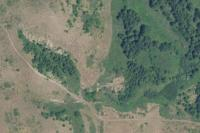

In [3]:
# gather the NAIP item
naip_item = gis.content.get("3f8d2d3828f24c00ae279db4af26d566")
naip_item

In [4]:
# gather the NAIP layer
lyr_naip = naip_item.layers[0]

In [5]:
# define extent by tuple
in_extent = (-13530675.228816083, 4545237.670432766, -13528866.137925146, 4547533.238415405) 

# unpack the extent tuple into individual variables
xmin, ymin, xmax, ymax = in_extent

# create a dictionary for the envelope
extent_dict = {'xmin': xmin,
  'ymin': ymin,
  'xmax': xmax,
  'ymax': ymax,
  'spatialReference': {'wkid': 3857}}

# create an envelope geometry
envelope = arcgis.geometry.Envelope(extent_dict) 

In [6]:
# determine the pixel size of the output

# NAIP Resolution
naip_res = 1 

# Web Mercator meters per unit
metersPerUnit = 1

# calculate the width and height of our output in pixels
w = int((xmax - xmin) * metersPerUnit / naip_res)
h = int((ymax - ymin) * metersPerUnit / naip_res)

In [7]:
# query the NAIP layer for available dates

df_naip = lyr_naip.query(
    where = "AcquisitionDate IS NOT NULL",
    geometry_filter = arcgis.geometry.filters.intersects(
        geometry=envelope, 
        sr=envelope.spatial_reference),
    as_df=True,
    )

In [8]:
# create a list of years and dates to export
years_and_dates = df_naip[['Year','AcquisitionDate']].to_dict('records')

#### 2.  Export tiff files.

Rather than exporting jpegs as we did in the previous tutorial, we'll export tiff files now.  These will be slightly bigger, take longer to export, and can't be displayed in the notebook, but since we already know the data looks good we can proceed with confidence.

Modify the code from the previous tutorial to export tiff files instead of jpegs.

In [9]:
for year_and_date in years_and_dates:
    
    # unpack the year
    year = year_and_date['Year']
    
    # unpack the filter date
    filter_date = year_and_date['AcquisitionDate']
    
    print("Exporting", year)
    
    # export the image
    export_image = lyr_naip.export_image(
        bbox = envelope,
        bbox_sr = 3857, 
        image_sr = 3857, 
        time = filter_date, # timestamp changed to iterating date
        rendering_rule = {'rasterFunction': "NaturalColor"}, 
        f = "image", 
        export_format='tiff', # changed the export format to tiff
        size = [w,h], 
        save_folder = r".", 
        save_file = rf"mountain_house_{year}.tif", # file name changed to include year - file extension changed to tif
        )
    

Exporting 2012
Exporting 2014
Exporting 2016
Exporting 2018
Exporting 2020
Exporting 2022


## Set Up Land Classification Model

In our effort to quantify the amount of development in Mountain House, we'll need to classify pixels by whether or not they're developed.  You could train your own model using some very similar methodology.  That's a pretty advanced and time-consuming activity though.  Luckily, the Living Atlas also contains some pretrained models that will work with this data.

#### 1.  Find the model in the Living Atlas.

Similarly to how we accessed the NAIP data in the Living Atlas, we can also find the model we're interested in.  Again, we'll access the item in ArcGIS Online via its Item ID.

<Item title:"High Resolution Land Cover Classification - USA" type:Deep Learning Package owner:esri_analytics>
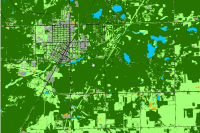

In [10]:
model_item = gis.content.get("a10f46a8071a4318bcc085dae26d7ee4") 
model_item

Check out the documentation for the model linked above.  It's a Deep Learning Package that is pretrained to classify the pixels in an imagery raster.  It has already been trained to identify the imagery signatures that are most likely to indicate landcover categories like buildings, roads, water, open land, etc. This model will apply those learned relationships and dependencies to our imagery to classify each pixel as the landcover category that it most likely corresponds to."

#### 2.  Download the model locally.

To use the model on this data that you've collected, you'll need to download it locally.  Luckily that's pretty easy using the ArcGIS API for Python.

In [11]:
model_local = model_item.download(
    save_path = r".", 
    file_name = model_item.name
) 
model_local

'.\\HighResolutionLandCoverClassification_USA.dlpk'

## Use the Model to Classify a Raster

You've retrieved imagery and chosen the pretrained model most appropriate for your use case and available imagery. Not it's time to apply the model to your images and review the resulting predictions.

#### 1.  Import arcpy.

To perform this analysis locally, you'll need the `arcpy` package.

In [12]:
import arcpy

#### 2.  Choose the path for an input raster.

Start with the 2022 raster then use the `arcpy.Exists()` function to confirm that you have a valid file path

In [13]:
input_raster_2022 = './mountain_house_2022.tif'

In [14]:
arcpy.Exists(input_raster_2022)

True

#### 3.  Classify your raster.

Now you can use the **Classify Pixels Using Deep Learning** tool in the **Imagery Analysis** toolbox to classify the data.

C:\Program Files\ArcGIS\Pro\Resources\ArcPy\arcpy\geoprocessing\_base.py:512: UserWarning: Missing (optional) PRF Method/Property: 'isLicensed'
  return lambda *args: val(*gp_fixargs(args, True))
C:\Program Files\ArcGIS\Pro\Resources\ArcPy\arcpy\geoprocessing\_base.py:512: UserWarning: Missing (optional) PRF Method/Property: 'selectRasters'
  return lambda *args: val(*gp_fixargs(args, True))
C:\Program Files\ArcGIS\Pro\Resources\ArcPy\arcpy\geoprocessing\_base.py:512: UserWarning: Missing (optional) PRF Method/Property: 'getFields'
  return lambda *args: val(*gp_fixargs(args, True))
C:\Program Files\ArcGIS\Pro\Resources\ArcPy\arcpy\geoprocessing\_base.py:512: UserWarning: Missing (optional) PRF Method/Property: 'vectorize'
  return lambda *args: val(*gp_fixargs(args, True))
C:\Program Files\ArcGIS\Pro\Resources\ArcPy\arcpy\geoprocessing\_base.py:512: UserWarning: Missing (optional) PRF Method/Property: 'getGeometryType'
  return lambda *args: val(*gp_fixargs(args, True))


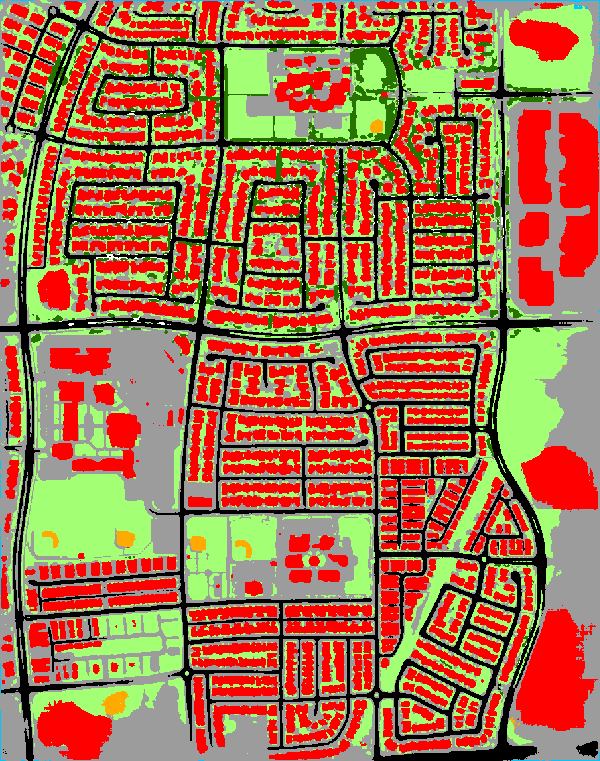

In [11]:
classified_2022 = arcpy.ia.ClassifyPixelsUsingDeepLearning(
    in_raster = input_raster_2022,
    in_model_definition = model_local,
)
classified_2022

We can render the output raster directly in our Jupyter Notebook or in ArcGIS Pro.  If you are running this in ArcGIS Pro, the raster will be added to your active Map automatically.  From there you can view the symbology and attribute table.  If you're in a Jupyter Notebook, however, you don't have that option.  You can use the function below to generate and symbolize a DataFrame based on the Raster Attribute Table (`.RAT` property of the raster object.)

In [63]:
def raster_legend(raster_file):
    
    # create a DataFrame from the Raster Attribute Table (RAT) of the raster
    df = pd.DataFrame(raster_file.RAT)
    
    # combine red, green, blue columns into one
    df['RGB'] = "(" + df['Red'].astype(str) + ',' \
    + df['Green'].astype(str) + ',' + df['Blue'].astype(str) + ", .75)"
    
    # define a style colorizer
    def colorize(s):
        return [f'background-color: rgba{color}' for color in s]
    
    # apply that colorizer to the DataFrame
    df = df.style.apply(colorize, subset=['RGB'])
    
    return df

raster_legend(classified_2022)

,OBJECTID,Value,Class,Red,Green,Blue,RGB
0,1,1,Water,0,197,255,"(0,197,255, .75)"
1,2,2,Wetlands,0,168,132,"(0,168,132, .75)"
2,3,3,Tree Canopy,38,115,0,"(38,115,0, .75)"
3,4,4,Shrubland,76,230,0,"(76,230,0, .75)"
4,5,5,Low Vegetation,163,255,115,"(163,255,115, .75)"
5,6,6,Barren,255,170,0,"(255,170,0, .75)"
6,7,7,Structures,255,0,0,"(255,0,0, .75)"
7,8,8,Impervious Surfaces,156,156,156,"(156,156,156, .75)"
8,9,9,Impervious Roads,0,0,0,"(0,0,0, .75)"


## Determine Structural Cover

Assuming we're interested in the amount of structural devleopment in our area of interest, we could just do some basic math to determine the percentage of pixels that are classified as structures.

#### 1.  Convert the raster to a NumPy array.

In addition to using geoprocessing tools to work with rasters, you can turn them into raw data in Python and work with them directly.  This works great for relatively small rasters like we're working with here.  

In [22]:
import numpy as np
array_2022 = arcpy.RasterToNumPyArray(classified_2022)

In [15]:
type(array_2022)

<class 'numpy.ndarray'>

In [16]:
array_2022

array([[1, 1, 1, 1, ..., 1, 1, 1, 1],
       [1, 1, 1, 1, ..., 1, 1, 1, 1],
       [1, 1, 8, 8, ..., 1, 1, 1, 1],
       [1, 1, 8, 8, ..., 1, 1, 1, 1],
       ...,
       [1, 1, 1, 1, ..., 1, 1, 1, 1],
       [1, 1, 1, 1, ..., 1, 1, 1, 1],
       [1, 1, 1, 1, ..., 1, 1, 1, 1],
       [1, 1, 1, 1, ..., 1, 1, 1, 1]])

When you look at this new array, you'll see a list of lists.  Each of the inner list represents a row of pixels.  Within each row, each pixel is represented by a number representing its class.

#### 2.  Test for structures.

Now that you've got your classified raster converted to an array, you can test each one of those pixels to determine whether or not it's a structure.

In [19]:
array_2022 == 7

array([[False, False, False, False, ..., False, False, False, False],
       [False, False, False, False, ..., False, False, False, False],
       [False, False, False, False, ..., False, False, False, False],
       [False, False, False, False, ..., False, False, False, False],
       ...,
       [False, False, False, False, ..., False, False, False, False],
       [False, False, False, False, ..., False, False, False, False],
       [False, False, False, False, ..., False, False, False, False],
       [False, False, False, False, ..., False, False, False, False]])

You can also use built-in NumPy functions to sum the number of pixels that are classified as structures.

In [27]:
structure_pixels = np.sum(array_2022 == 7)
structure_pixels

1328599

#### 3.  Calculate the percent of structure cover.

You've determined the number of pixels that are classified as structures.  Now all you need to know is the total number of pixels in the raster and you can calculate the percentage of area covered by structures.

In [26]:
total_pixels = array_2022.size
total_pixels

4151655

You can use the count of structure pixels and the total pixels to calculate the percentage of pixels classified as structures.

In [28]:
percent_structures = structure_pixels / total_pixels * 100
percent_structures

32.00167162252162

We see now that in 2022, the area of interest in Mountain House was approximately 32% covered by structures.  Now let's take a look at 2012 and see if we can quantify the change.

## Calculate Change Over Time

We can repeat our analysis on the 2012 raster so that we can repeat our analysis.

#### 1.  Classify 2012 raster.

Repeat the classification that you did on the 2022 raster using the 2012 raster.

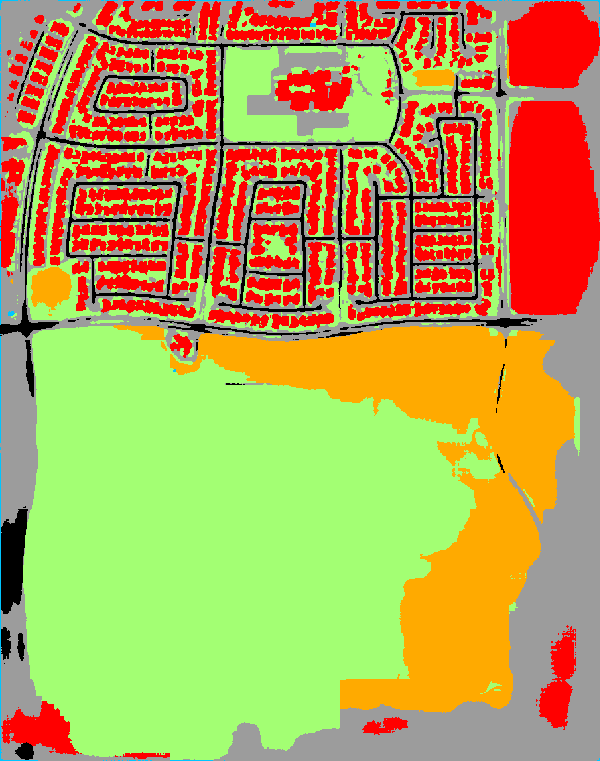

In [12]:
input_raster_2012 = "./mountain_house_2012.tif"
classified_2012 = arcpy.ia.ClassifyPixelsUsingDeepLearning(
    in_raster = input_raster_2012,
    in_model_definition = model_local,
)
classified_2012

#### 2.  Convert to NumPy array and calculate percent.

In [30]:
array_2012 = arcpy.RasterToNumPyArray(classified_2012)

In [31]:
# total pixels for 2012 raster
total_pixels_2012 = array_2012.size

# structure pixels for 2012
structure_pixels_2012 = np.sum(array_2012 == 7)

# calculate percent for 2012
percent_structures_2012 = structure_pixels_2012 / total_pixels_2012 * 100
percent_structures_2012

19.718329196428893

#### 3.  Calculate change in percent structure cover.

Subtract the 2012 percentage from the 2022 percentage to get the change in structure cover.  This will give you a good idea of how much change has happened.

In [33]:
percent_structures - percent_structures_2012

12.283342426092727

A 12% increase in structure footprints in a given area over the course of 10 years is fairly significant.

## Visualize Change Over Time

In addition to doing basic raster math, there is a large suite of geoprocessing tools included in the ArcPy package that can help reclassify and visualize your data in interesting ways.  One that will work well in this case is `ComputeChangeRaster`.

In [12]:
arcpy.ia.ComputeChangeRaster?

Use the code below to configure the geoprocessing tool to show only the pixels that have changed to structures.  To do this, you'll want the `from_classes` parameter to include all input classes and the `to_classes` parameter to only include 7 which represents structures.

In [35]:
change_raster = arcpy.ia.ComputeChangeRaster(
    from_raster = classified_2012,
    to_raster = classified_2022,
    compute_change_method = "CATEGORICAL_DIFFERENCE",
    from_classes="1;2;3;4;5;6;7;8;9",
    to_classes = "7",
    filter_method = "CHANGED_PIXELS_ONLY",
    define_transition_colors = "AVERAGE",
)

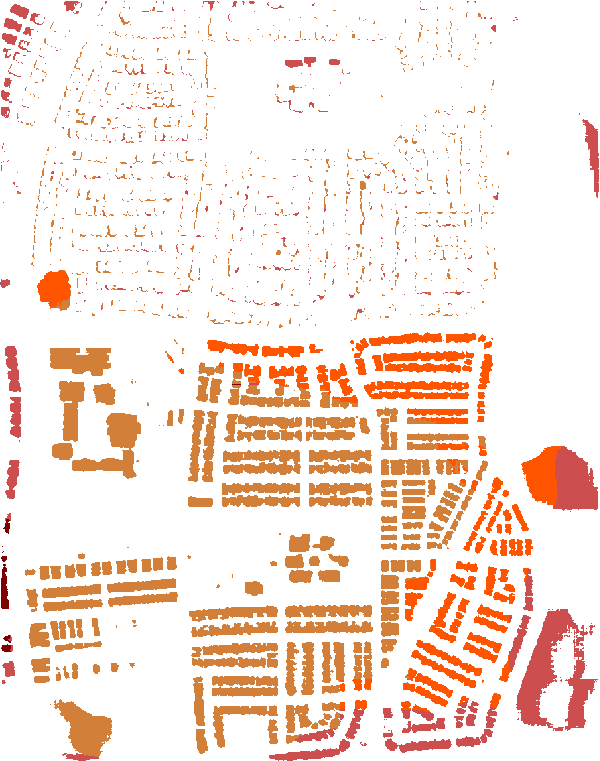

In [36]:
change_raster

Now you've created a raster that only shows pixels that are structures in 2022 that were not in 2012.

In [66]:
raster_legend(change_raster)

,OID,Value,Classvalue,Class_name,Class_From,Class_To,Red,Green,Blue,Alpha,Count,Area,RGB
0,0,0,10,Water->Structures,Water,Structures,127,98,127,255,125.000000,125.061879,"(127,98,127, .75)"
1,1,4,14,Low Vegetation ->Structures,Low Vegetation,Structures,209,127,57,255,432655.000000,432869.179466,"(209,127,57, .75)"
2,2,5,15,Barren->Structures,Barren,Structures,255,85,0,255,163525.000000,163605.950636,"(255,85,0, .75)"
3,3,6,16,Impervious Surfaces->Structures,Impervious Surfaces,Structures,205,78,78,255,138987.000000,139055.803461,"(205,78,78, .75)"
4,4,7,17,Impervious Roads->Structures,Impervious Roads,Structures,127,0,0,255,3964.000000,3965.962320,"(127,0,0, .75)"
5,5,8,18,Other,Other,Other,255,255,255,0,2823056.000000,2824453.512170,"(255,255,255, .75)"
6,6,9,19,No Change,Same,Same,255,255,255,0,589343.000000,589634.745546,"(255,255,255, .75)"
